In [1]:
import numpy as np, pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from datetime import datetime

%matplotlib inline
%config IPCompleter.greedy=True

In [2]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore',category=FutureWarning)

In [3]:
tlg = pd.read_csv('./data/top_line_growth/fredgraph/Quarterly.csv',parse_dates=['DATE'],index_col=['DATE'])
interest_rate = pd.read_csv('./data/taylor_rule/fredgraph/Monthly.csv',parse_dates=['DATE'],index_col=['DATE'])

In [4]:
print(interest_rate.shape)
interest_rate.head()

(784, 1)


,FEDFUNDS
DATE,
1954-07-01,0.80
1954-08-01,1.22
1954-09-01,1.06
1954-10-01,0.85
1954-11-01,0.83


In [5]:
tlg = tlg.asfreq('MS')

In [6]:
difference = interest_rate.diff()
decision = []
for i in difference['FEDFUNDS']:
    if i > 0:
        decision.append("increase")
    elif i < 0:
        decision.append("decrease")
    else:
        decision.append("maintain")
interest_rate['change_ir'] = interest_rate['FEDFUNDS'].diff()
interest_rate['decision'] = decision
interest_rate.drop(labels=['change_ir'], axis=1, inplace=True)
interest_rate.head()

,FEDFUNDS,decision
DATE,,
1954-07-01,0.80,maintain
1954-08-01,1.22,increase
1954-09-01,1.06,decrease
1954-10-01,0.85,decrease
1954-11-01,0.83,decrease


# Merge DataFrames

In [7]:
df = pd.merge(tlg,interest_rate,how='right',on='DATE')
print(df.shape)
df.head()

(784, 3)


,A455RC1Q027SBEA,FEDFUNDS,decision
DATE,,,
1954-07-01,-2.85622,0.80,maintain
1954-08-01,NaN,1.22,increase
1954-09-01,NaN,1.06,decrease
1954-10-01,5.29912,0.85,decrease
1954-11-01,NaN,0.83,decrease


In [8]:
df.ffill(inplace=True)

In [9]:
df.columns

Index(['A455RC1Q027SBEA', 'FEDFUNDS', 'decision'], dtype='object')

In [10]:
df['A455RC1Q027SBEA_12'] = df['A455RC1Q027SBEA'].rolling(window=12).mean()
df.head()

,A455RC1Q027SBEA,FEDFUNDS,decision,A455RC1Q027SBEA_12
DATE,,,,
1954-07-01,-2.85622,0.80,maintain,NaN
1954-08-01,-2.85622,1.22,increase,NaN
1954-09-01,-2.85622,1.06,decrease,NaN
1954-10-01,5.29912,0.85,decrease,NaN
1954-11-01,5.29912,0.83,decrease,NaN


In [11]:
df = df.dropna(axis=0)

In [12]:
df.isnull().sum()

A455RC1Q027SBEA       0
FEDFUNDS              0
decision              0
A455RC1Q027SBEA_12    0
dtype: int64

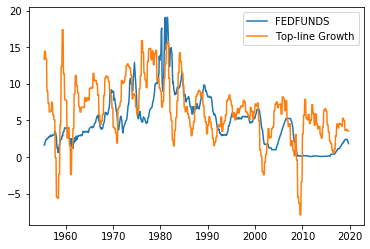

In [13]:
plt.plot(df['FEDFUNDS'], label='FEDFUNDS');
plt.plot(df['A455RC1Q027SBEA'], label='Top-line Growth');
plt.legend();

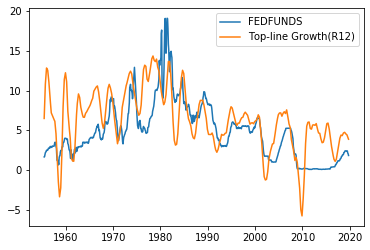

In [14]:
plt.plot(df['FEDFUNDS'], label='FEDFUNDS');
plt.plot(df['A455RC1Q027SBEA_12'], label='Top-line Growth(R12)');
plt.legend();

In [15]:
# convert target variable to numeric
df.replace({'decision':{'maintain':1,'increase':2,'decrease':3}},inplace=True)

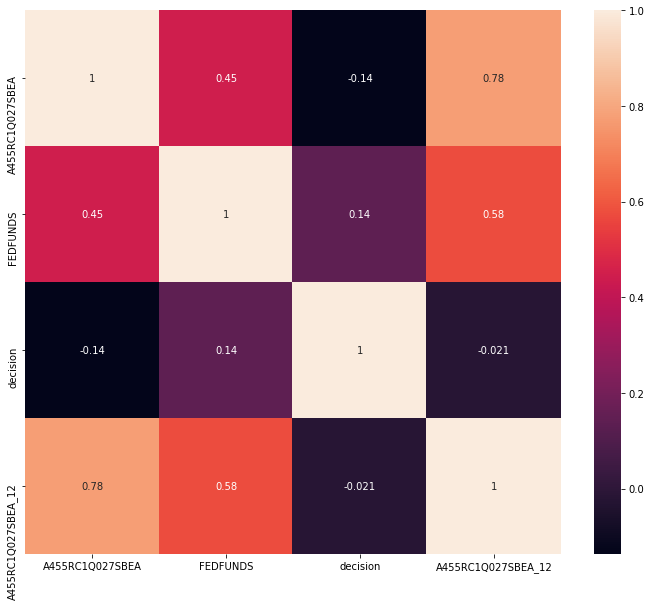

In [16]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = df.corr()
ax = sns.heatmap(cor, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [17]:
# split into 75% training data and 25% test data
df = df.drop('FEDFUNDS',axis=1)
train_size = int(len(df) * .75)
train, test = df[0:train_size], df[train_size:len(df)]

# Model

In [18]:
X = train.drop('decision',axis=1)
y = train['decision']

In [19]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import mglearn

/Users/kenricklow/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/kenricklow/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
# scale data
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [21]:
lr = LogisticRegression(multi_class='auto',random_state=42).fit(X_train,y_train)
train_score = cross_val_score(lr, X_train, y_train, cv=5, scoring='accuracy')
prediction = lr.predict(X_test)
print("Train Accuracy: {:.3f}".format(train_score.mean()))
print("Accuracy: {:.3f}".format(accuracy_score(y_test, prediction)))
# print("Confusion matrix: \n{}".format(confusion_matrix(y_test, prediction)))

Train Accuracy: 0.650
Accuracy: 0.655


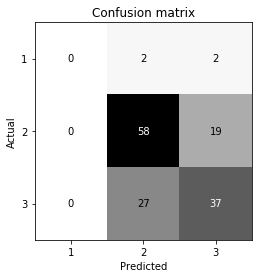

In [22]:
scores_image = mglearn.tools.heatmap(confusion_matrix(y_test, prediction),
                                     xlabel='Predicted',
                                    ylabel='Actual',
                                    xticklabels=[1,2,3],
                                    yticklabels=[1,2,3],
                                    cmap=plt.cm.gray_r,
                                    fmt="%d")
plt.title("Confusion matrix")
plt.gca().invert_yaxis()
# row = False Negative
# column = False Positive

In [23]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         4
           2       0.67      0.75      0.71        77
           3       0.64      0.58      0.61        64

    accuracy                           0.66       145
   macro avg       0.43      0.44      0.44       145
weighted avg       0.64      0.66      0.64       145



/Users/kenricklow/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [24]:
pred_df = pd.DataFrame({'true_values': y_test,
                        'prediction' : prediction})
print(pred_df.loc[pred_df['true_values'] != pred_df['prediction']].shape)
pred_df.sort_index().loc[pred_df['true_values'] != pred_df['prediction']]

(50, 2)


,true_values,prediction
DATE,,
1956-12-01,2,3
1958-06-01,2,3
1958-08-01,2,3
1958-10-01,2,3
1959-12-01,3,2
1960-01-01,1,2
1960-02-01,3,2
1962-04-01,3,2
1962-12-01,3,2


In [25]:
model_coef = pd.DataFrame(data = lr.coef_,
             index = lr.classes_,
             columns = X.columns)
model_coef

,A455RC1Q027SBEA,A455RC1Q027SBEA_12
1,-0.201430,-0.199486
2,0.813316,-0.024605
3,-0.770447,0.060751


# Test

In [26]:
actual = test['decision']
test = test.drop('decision', axis=1)

In [27]:
test = ss.fit_transform(test)

Accuracy: 0.505


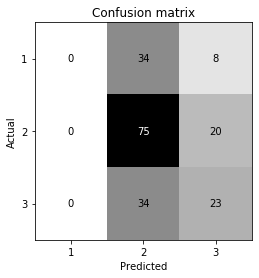

In [28]:
prediction = lr.predict(test)
print("Accuracy: {:.3f}".format(accuracy_score(actual, prediction)))
# print("Confusion matrix: \n{}".format(confusion_matrix(actual, prediction)))

scores_image = mglearn.tools.heatmap(confusion_matrix(actual, prediction),
                                     xlabel='Predicted',
                                    ylabel='Actual',
                                    xticklabels=[1,2,3],
                                    yticklabels=[1,2,3],
                                    cmap=plt.cm.gray_r,
                                    fmt="%d")
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

In [29]:
pred_df = pd.DataFrame({'true_values': actual,
                        'prediction' : prediction})
print(pred_df.loc[pred_df['true_values'] != pred_df['prediction']].shape)
pred_df.sort_index().loc[pred_df['true_values'] != pred_df['prediction']]

(96, 2)


,true_values,prediction
DATE,,
2003-09-01,3,2
2003-10-01,1,2
2003-11-01,3,2
2003-12-01,3,2
2004-03-01,3,2
...,...,...
2019-05-01,3,2
2019-06-01,3,2
2019-08-01,3,2
